# PyTorch Adversarial Attack (in Black-Box)

### (1) import

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import random
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

### (2) 사용 기기 설정

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

### (3) 하이퍼 파라미터 셋팅

In [4]:
EPOCHS     = 300
BATCH_SIZE = 128

MODEL_PATH = './model/PreTrained ResNet/preTrainedResNet_mnist.pt'

### (4) 공격할 모델 가져오기
---------------------------------------------------------------------------
CIFAR-10으로 미리 학습된 모델을 가져올 것이다.

물론, 이 모델 그대로 FGSM 공격 이미지를 생성할 수는 있지만,
BlackBox인 상황이라고 가정하고 진행할 것이기에,

모방 모델을 만들어 FGSM 공격 이미지를 생성할 것이다.

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 7)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [7]:
willBeHackedModel = torch.load(MODEL_PATH)
willBeHackedModel.eval()

ResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

### (5) 데이터셋 가져오기
------------------------------------------------------------
모방 모델 또한 CIFAR-10으로 학습할 예정이다. 같은 라벨 클래스를 가진 데이터셋이 존재하지 않아 같은 것으로 학습하겠다.
어차피 같은 것이든 아니든, 본 CIFAR-10의 y값은 쓰지 않을 것이고, 기존 모델의 분류값을 y값으로 사용할 것이다.

In [8]:
train_cifar_loader = torch.utils.data.DataLoader(
    datasets.MNIST('E:\Dataset\mnist',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=1, shuffle=True)
test_cifar_loader = torch.utils.data.DataLoader(
    datasets.MNIST('E:\Dataset\mnist',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=1, shuffle=True)

In [9]:
for batch_idx, (data, target) in enumerate(train_cifar_loader):
    print(target.data)
    break

tensor([8])


In [73]:
class CustomDataset(Dataset): 
  def __init__(self, cifar, _model):
    self.x_data = []
    self.y_data = None
    self.mix = {}
    self.model = _model
    
    for batch_idx, (data, target) in enumerate(cifar):
        self.x_data.append(data)
    random.shuffle(self.x_data)

  def __len__(self): 
    return len(self.x_data)

  def __getitem__(self, idx): 
    x = self.x_data[idx]
    y = self.model(x).max(1, keepdim=False)[1].item()
    return x.squeeze(0), y

In [74]:
train_loader = DataLoader(CustomDataset(train_cifar_loader, willBeHackedModel), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(CustomDataset(test_cifar_loader, willBeHackedModel), batch_size=BATCH_SIZE, shuffle=True)

### (6) 모방 모델 만들기
------------------------------------------------------------
모방 모델은 ResNet으로 만들 것이다.
어차피 실제로 할 때도 머신러닝 지식에 의해 개발자가 직접 선정한다고 하니...

실제로 할 때는 모델을 정확하게 맞출 수 없음으로, 약간 다른 점을 주기 위해서, BasicBlock를 한 층 더 늘렸다. 이게 성능의 어떤 영향을 주든 BlackBox를 위한 코드니 차별점을 주기 위해 어쩔 수 없다.

In [75]:
class ImitationResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ImitationResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(48, 2, stride=2)
        self.layer4 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [76]:
model = ImitationResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [97]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    bar_total = tqdm_notebook(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in bar_total:
        bar_total.set_description("{0}번째 학습 - {1}번 배치".format(epoch, batch_idx))
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        #print(output.data)
        #output = output.max(1, keepdim=True)[1]
        #target = torch.max(target, 2)[1].squeeze(1)
        #print(output.data)
        #print(target.data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [104]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    lastoutput = None
    lasttarget = None
    with torch.no_grad():
        bar_total = tqdm_notebook(enumerate(test_loader), total=len(test_loader))
        for batch_idx, (data, target) in bar_total:
            bar_total.set_description("테스트 중 - {0}번 배치".format(batch_idx))
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            #target = torch.max(target, 2)[1].squeeze(1)
            lastoutput = output
            lasttarget = target
            # 배치 오차를 합산
            
            loss = F.cross_entropy(output.float(), target.long(), reduction='sum')
            test_loss += loss.item()
            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy, lastoutput.data, pred.data, lasttarget.data

In [99]:
def save_checkpoint(path, epoch, model, optimizer, scheduler):
    state = {
        'Epoch': epoch,
        'State_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, path)
    
def load_checkpoint(path, model, optimitzer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['State_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = int(checkpoint['Epoch'])
    return model, optimizer, epoch
    

### (7) FGSM 이미지 생성

In [100]:
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()
    perturbed_image = image + epsilon * sign_gradient
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def getPertubedImage(img_tensor, target, epsilon, model):
    img_tensor = img_tensor#.unsqueeze(0)
    img_tensor.requires_grad_(True)
    output = model(img_tensor)
    loss = F.nll_loss(output, target) 
    
    model.zero_grad()
    
    loss.requires_grad_(True)
    loss.backward()
    
    gradient = img_tensor.grad.data
    perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
    return perturbed_data#.squeeze(0)

In [101]:
def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.detach().numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

In [102]:
def test_FGSM_attack(model, willBeHackedModel, dataloader, epsilon=0.07) :
    success_num=0
    bar_total = tqdm_notebook(enumerate(dataloader), total=len(dataloader))
    for batch_idx, (data, target) in bar_total:            
        realTarget = target
        perturbed_image = getPertubedImage(data, realTarget, epsilon, model)
        #if willBeHackedModel(perturbed_image).max(1, keepdim=True)[1].item() != model(perturbed_image).max(1, keepdim=True)[1].item() :
            #continue
        #if target.item() == willBeHackedModel(perturbed_image).max(1, keepdim=True)[1].item() or target.item() == model(perturbed_image).max(1, keepdim=True)[1].item() :
            #continue
        imshow(data[0])
        print("모범 답안 : " + str(target.item()))
        print("----------------------------------------------------------------------------------------------------")
        print("원본 이미지 원본 모델 예측 : " + str(willBeHackedModel(data).max(1, keepdim=False)[1].item()))
        print("원본 이미지 모방 모델 예측 : " + str(model(data).max(1, keepdim=False)[1].item()))
        print("----------------------------------------------------------------------------------------------------")

        realTarget = target
        perturbed_image = getPertubedImage(data, realTarget, epsilon, model)
        #pic = np.transpose(perturbed_image.detach().numpy()[0], (1, 2, 0))
        #plt.imshow(pic)
        #plt.show()
        print("왜곡 이미지(타겟 = real) 원본 모델 예측 : " + str(willBeHackedModel(perturbed_image).max(1, keepdim=False)[1].item()))
        print("왜곡 이미지(타겟 = real) 모방 모델 예측 : " + str(model(perturbed_image).max(1, keepdim=False)[1].item()))
        print("----------------------------------------------------------------------------------------------------")
        originalTarget = willBeHackedModel(data).max(1, keepdim=True)[1].squeeze(0)
        perturbed_image = getPertubedImage(data, originalTarget, epsilon, model)
        print("왜곡 이미지(타겟 = 원본 모델) 원본 모델 예측 : " + str(willBeHackedModel(perturbed_image).max(1, keepdim=False)[1].item()))
        print("왜곡 이미지(타겟 = 원본 모델) 모방 모델 예측 : " + str(model(perturbed_image).max(1, keepdim=False)[1].item()))
        print("----------------------------------------------------------------------------------------------------")
        imitaionTarget = model(data).max(1, keepdim=True)[1].squeeze(0)
        perturbed_image = getPertubedImage(data, imitaionTarget, epsilon, model)
        print("왜곡 이미지(타겟 = 모방 모델) 원본 모델 예측 : " + str(willBeHackedModel(perturbed_image).max(1, keepdim=False)[1].item()))
        print("왜곡 이미지(타겟 = 모방 모델) 모방 모델 예측 : " + str(model(perturbed_image).max(1, keepdim=False)[1].item()))
        print("----------------------------------------------------------------------------------------------------")
        imitaionTarget = model(data).max(1, keepdim=True)[1].squeeze(0)
        perturbed_image = getPertubedImage(data, imitaionTarget, epsilon, willBeHackedModel)
        print("왜곡 이미지(모델 = 원본) 원본 모델 예측 : " + str(willBeHackedModel(perturbed_image).max(1, keepdim=False)[1].item()))
        print("왜곡 이미지(모델 = 원본) 모방 모델 예측 : " + str(model(perturbed_image).max(1, keepdim=False)[1].item()))
        break
    #print(str(success_num) + "/" + str(len(dataloader)))

### (8) 학습 시작

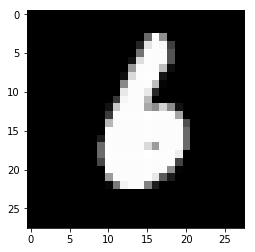

모범 답안 : 6
----------------------------------------------------------------------------------------------------
원본 이미지 원본 모델 예측 : 6
원본 이미지 모방 모델 예측 : 6
----------------------------------------------------------------------------------------------------
왜곡 이미지(타겟 = real) 원본 모델 예측 : 1
왜곡 이미지(타겟 = real) 모방 모델 예측 : 1
----------------------------------------------------------------------------------------------------
왜곡 이미지(타겟 = 원본 모델) 원본 모델 예측 : 1
왜곡 이미지(타겟 = 원본 모델) 모방 모델 예측 : 1
----------------------------------------------------------------------------------------------------
왜곡 이미지(타겟 = 모방 모델) 원본 모델 예측 : 1
왜곡 이미지(타겟 = 모방 모델) 모방 모델 예측 : 1
----------------------------------------------------------------------------------------------------
왜곡 이미지(모델 = 원본) 원본 모델 예측 : 1
왜곡 이미지(모델 = 원본) 모방 모델 예측 : 1
----------------------------------------------------------------------------------------------------
[2] Test Loss: 0.1509, Accuracy: 95.25%


In [ ]:
already=2
for epoch in range(already, EPOCHS + 1):
    scheduler.step()
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy, _o, _p, _t = evaluate(model, test_loader)
    clear_output(wait=True)
    #print("아웃풋 : " + str(_o))
    #print("모방 모델의 답안 : " + str(_p))
    #print("원본 모델의 답안 : " + str(_t))
    test_FGSM_attack(model, willBeHackedModel, test_cifar_loader)
    print("----------------------------------------------------------------------------------------------------")
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

In [72]:
test_FGSM_attack(model, willBeHackedModel, test_loader, epsilon=0.1)

C:\Users\LHZ\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: 1D target tensor expected, multi-target not supported

In [71]:
torch.save(model, './model/Attack Model/model_3.pt')

C:\Users\LHZ\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ImitationResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\LHZ\anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BasicBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [81]:
save_checkpoint("checkpoints/model_1/checkpoints3.tar", already, model, optimizer, scheduler)

In [30]:
_m, _o, _e = load_checkpoint("checkpoints/model_1/checkpoints1.tar", ImitationResNet(), optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005), optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1))

C:\Users\LHZ\anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


(3.7169133827209473,
 65.56,
 tensor([[ -1.3295,  -8.1340, -13.4282,  -5.3378,   5.5988,   5.3002, -11.8622,
           43.7479,  -6.3951,  -8.1678],
         [ -9.6390,  -5.4726,  -5.8292,   9.4391,  -3.4087,  26.4297,  -5.8986,
           12.8656, -12.2009,  -6.2901],
         [ -2.3526,   3.7780,  -6.7665,  -1.7601,  -8.3274,  -5.3754,  -6.2733,
           -0.8379,   9.4810,  18.4347],
         [ -1.9152,  14.9927,  -5.6941,   2.5607,  -8.3189,  -0.5827,   1.8324,
           -6.6908,   6.9678,  -3.1544],
         [  6.8326,   2.6636,   6.0283,  -3.5994,  -5.0497,  -8.0440,  -3.6280,
           -2.1835,  13.7585,  -6.7769],
         [-10.1441,  11.5962,  -4.4965,  -0.2949,  -1.7003,   2.7460,  -0.0768,
           -7.5410,  -8.6675,  18.5780],
         [-11.3807, -15.3519, -12.4055,  24.9558,   2.2705,  32.0103,   2.7885,
            5.3101, -18.3358,  -9.8681],
         [ 27.6686,  -5.6602,  -0.4504,   6.8777,  -0.7883,  -9.7300,  -5.5564,
           -3.4166,  -2.9285,  -6.0172],
   